# Szombathely csapadékeloszlása és modellezett intercepciója 1901-2010 időszakban

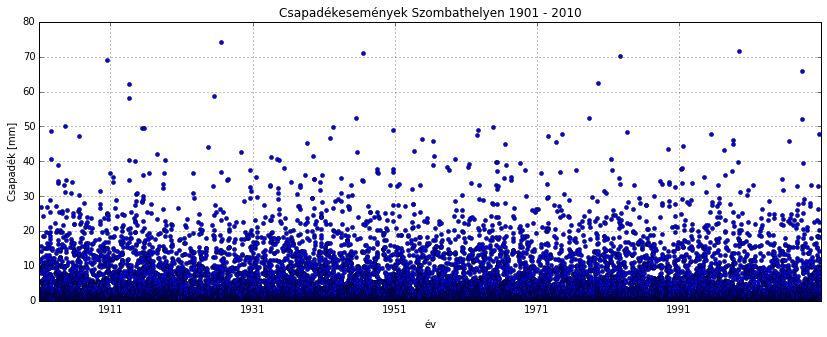

In [1]:
%matplotlib inline

# Basic configurations
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math


dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')

# define source
dfSrc = 'https://raw.githubusercontent.com/jsheperd/forest_water/master/data/SZO_d.txt'
Src = u'Szombathely'

# load data
dfPrec = pd.read_csv(dfSrc, sep=';', parse_dates=['#datum'], date_parser=lambda x: pd.datetime.strptime(x, '%Y-%m-%d'))
dfPrec.set_index(dfPrec['#datum'])


fig, ax = plt.subplots(figsize=(14, 5))
plt.plot_date(dfPrec['#datum'], dfPrec['d_rs'], ms=4)
plt.ylabel(u'Csapadék [mm]')
plt.xlabel(u'év')
plt.title(u'Csapadékesemények %sen 1901 - 2010' % Src)
plt.grid(True)

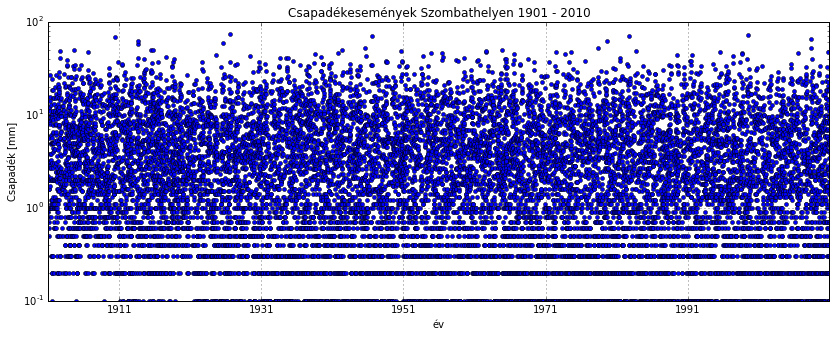

In [2]:
fig, ax = plt.subplots(figsize=(14, 5))
plt.yscale('log')
plt.plot_date(dfPrec['#datum'], dfPrec['d_rs'], ms=4)
plt.ylabel(u'Csapadék [mm]')
plt.xlabel(u'év')
plt.title(u'Csapadékesemények %sen 1901 - 2010' % Src)
plt.grid(True)

<__main__.scalableHist instance at 0x0000000008347E08>

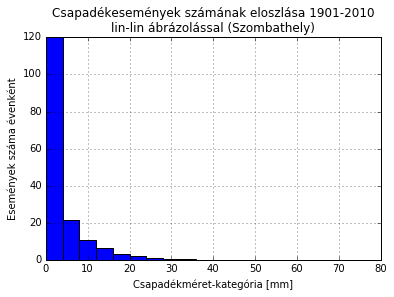

In [3]:
# Intercepciós veszteség
def makeInterceptor(capacity):
    return lambda p: capacity*(1-math.exp(-p/capacity))

# Calculate interception, usable precipitation
class scalableHist:
    def __init__(self, col, bins=20, title=''):
        self.col = col
        self.bins = bins
        self.title = title
        (self.hist, self.bins) = np.histogram(col, bins=self.bins, range=(0, 80))
        self.center = (self.bins[1:] + self.bins[:-1]) / 2.0
        self.width = self.bins[1] - self.bins[0]
                
    def scale(self, factor):
        self.hist = self.hist * factor
        return self
        
    def plot(self, logy=False, xlabel=None, ylabel=None):
        plt.grid()
        plt.bar(self.center, self.hist, align='center', width=self.width)
        if self.title:
            plt.title(self.title)
        if logy:
            plt.yscale('log')
        if xlabel:
            plt.xlabel(xlabel)
        if ylabel:
            plt.ylabel(ylabel)
        return self

    
title = u'Csapadékesemények számának eloszlása 1901-2010\nlin-lin ábrázolással (%s)' % Src
ylabel = u'Események száma évenként'
xlabel = u'Csapadékméret-kategória [mm]'
dfEventNum = dfPrec[dfPrec.d_rs.notnull()]
s1 = scalableHist(dfEventNum.d_rs, title=title).scale(1/110.0)
s1.plot(xlabel=xlabel, ylabel=ylabel)

<__main__.scalableHist instance at 0x0000000008347E08>

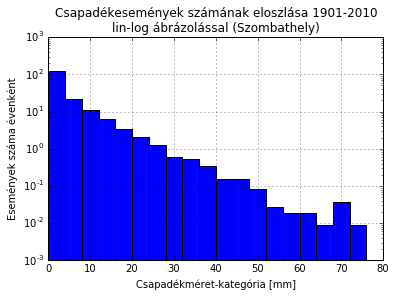

In [4]:
s1.title = u'Csapadékesemények számának eloszlása 1901-2010\nlin-log ábrázolással (%s)' % Src
s1.plot(True, xlabel=xlabel, ylabel=ylabel)

In [5]:
# intercepciós veszteség számítása eseményenként
dfPrec['c2'] = map(makeInterceptor(2.0), dfPrec.d_rs)
dfPrec['c3'] = map(makeInterceptor(3.0), dfPrec.d_rs)
dfPrec['c4'] = map(makeInterceptor(4.0), dfPrec.d_rs)

# hasznosítható csapadék
dfPrec['h2'] = dfPrec.d_rs - dfPrec.c2
dfPrec['h3'] = dfPrec.d_rs - dfPrec.c3
dfPrec['h4'] = dfPrec.d_rs - dfPrec.c4

dfPrec['Year'] = map(lambda d: d.year, dfPrec['#datum'])
dfPrec['Decad'] = map(lambda d: 1+((d.year-1)/10)*10, dfPrec['#datum'])

dfPrec['Month'] = map(lambda d: d.month, dfPrec['#datum'])
dfPrec['Vegetation'] = map(lambda d: ((5<=d.month) & (d.month<=10)), dfPrec['#datum'])

(0, 600)

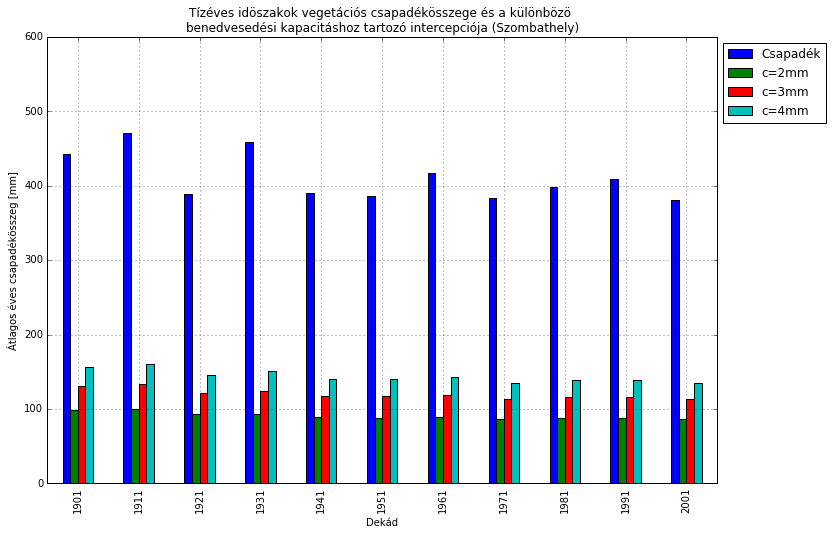

In [6]:
#Vegetációs időszak csapadékeseményei
dfVeg = dfPrec[dfPrec.Vegetation]
dfModPrec = dfVeg.groupby(['Decad'])['d_rs', 'c2', 'c3', 'c4'].sum()
# Tízéves átlag képzése
dfModPrec.d_rs /= 10.0
dfModPrec.c2 /= 10.0
dfModPrec.c3 /= 10.0
dfModPrec.c4 /= 10.0

dfModPrec.plot(kind='bar', figsize=(12, 8))
plt.title(u'Tízéves idöszakok vegetációs csapadékösszege és a különbözö \nbenedvesedési kapacitáshoz tartozó intercepciója (%s)' % Src)
plt.xlabel(u'Dekád')
plt.ylabel(u'Átlagos éves csapadékösszeg [mm]')
plt.legend(loc="upper left", bbox_to_anchor=(1,1), labels=[u'Csapadék', 'c=2mm', 'c=3mm', 'c=4mm'])
plt.grid(True)
plt.ylim((0,600))

(0, 600)

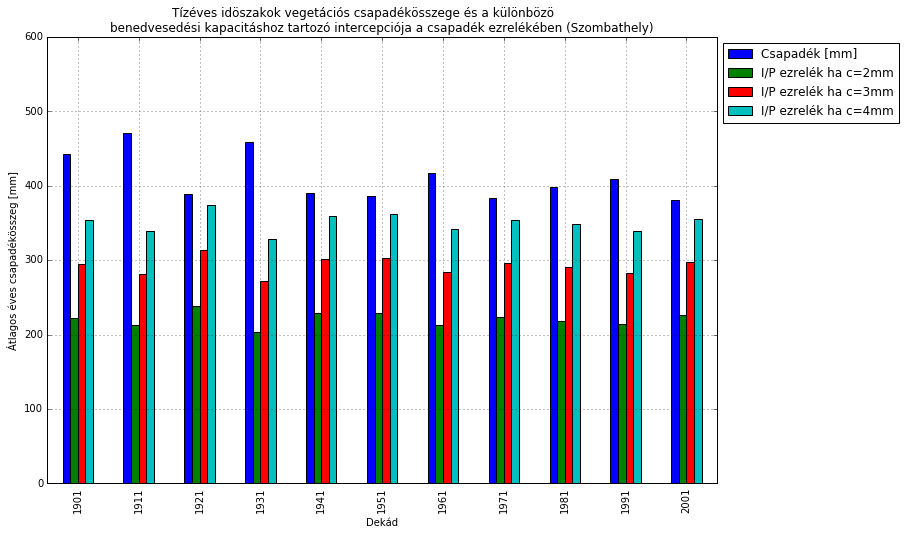

In [7]:
dfModPrec['r2'] = 1000* dfModPrec.c2 / dfModPrec.d_rs
dfModPrec['r3'] = 1000* dfModPrec.c3 / dfModPrec.d_rs
dfModPrec['r4'] = 1000* dfModPrec.c4 / dfModPrec.d_rs

dfModPrec[['d_rs', 'r2', 'r3', 'r4']].plot(kind='bar', figsize=(12, 8))
plt.title(u'Tízéves idöszakok vegetációs csapadékösszege és a különbözö\
          \nbenedvesedési kapacitáshoz tartozó intercepciója a csapadék ezrelékében (%s)' % Src)
plt.xlabel(u'Dekád')
plt.ylabel(u'Átlagos éves csapadékösszeg [mm]')
plt.legend(loc="upper left", bbox_to_anchor=(1,1), 
           labels=[u'Csapadék [mm]', u'I/P ezrelék ha c=2mm', u'I/P ezrelék ha c=3mm', u'I/P ezrelék ha c=4mm'])
plt.grid(True)
plt.ylim((0,600))